<a href="https://colab.research.google.com/github/ej-emjiang/DIMe/blob/main/ads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [ ]:
from google.colab import drive

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from datetime import date
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd # tukey's range test
import statistics

In [ ]:
drive.mount('/content/gdrive', force_remount = True)
%cd /content/gdrive/My Drive/DIME/ads

Mounted at /content/gdrive
/content/gdrive/My Drive/DIME/ads


Preparing data.

In [ ]:
dailyData = pd.read_csv("! Time_series(2023.04.01-2023.04.30).csv")

dailyData['Clicks'] == dailyData['Clicks'].apply(int)
dailyData['Impressions'] = dailyData['Impressions'].apply(
    lambda x: int(''.join(x.split(',')))) # combatting , in number

dailyData['Avg. CPC'] = dailyData['Avg. CPC'].apply(
    lambda x: float(x[1:])) # removing the $

dailyData['Cost'] = dailyData['Cost'].apply(
    lambda x: float(x[1:])) # removing the $

dailyData['CTR'] = dailyData['Clicks'] / dailyData['Impressions'] # getting click through rate

dailyData['Day of Week'] = dailyData['Date'].apply(
    lambda x: x.split(',')[0]
)

dailyData['dateTime'] = pd.to_datetime(
    {
        'month': 4, # everything is in April
        'day': dailyData['Date'].apply(
            lambda x: x.split(',')[1].split()[-1] # get Mon DD, then just DD
        ),
        'year': 2023 # Everything is in 2023
    }
)

dailyData['Ordinal Date'] = dailyData['dateTime'].apply(
    lambda date: date.toordinal()
)

# dailyData.info()
dailyData.head()

,Date,Clicks,Impressions,Avg. CPC,Cost,CTR,Day of Week,dateTime,Ordinal Date
0,"Sat, Apr 1, 2023",29,2015,0.30,8.65,0.014392,Sat,2023-04-01,738611
1,"Sun, Apr 2, 2023",24,3331,0.26,6.29,0.007205,Sun,2023-04-02,738612
2,"Mon, Apr 3, 2023",50,5447,0.47,23.40,0.009179,Mon,2023-04-03,738613
3,"Tue, Apr 4, 2023",89,6528,0.47,41.96,0.013634,Tue,2023-04-04,738614
4,"Wed, Apr 5, 2023",78,9329,0.44,34.48,0.008361,Wed,2023-04-05,738615


In [ ]:
for col in dailyData.columns[1:-2]:
    print(f"Average {col} per day: {statistics.mean(dailyData[col])}.", end=' ')
    print(f"Standard deviation: {statistics.stdev(dailyData[col])}")

Average Clicks per day: 40. Standard deviation: 18.444698331816763
Average Impressions per day: 4535.666666666667. Standard deviation: 1982.253791005083
Average Avg. CPC per day: 0.6653333333333333. Standard deviation: 0.45113445761831883
Average Cost per day: 21.85. Standard deviation: 7.312779083975837
Average CTR per day: 0.009020624036480993. Standard deviation: 0.0028421765584138734


# Analyzing linear relationships

## Cost as a predicting factor

We plot a scatterplot with a best-fit line to visually assess the relationship between cost and impressions.

<Axes: xlabel='Cost', ylabel='Impressions'>

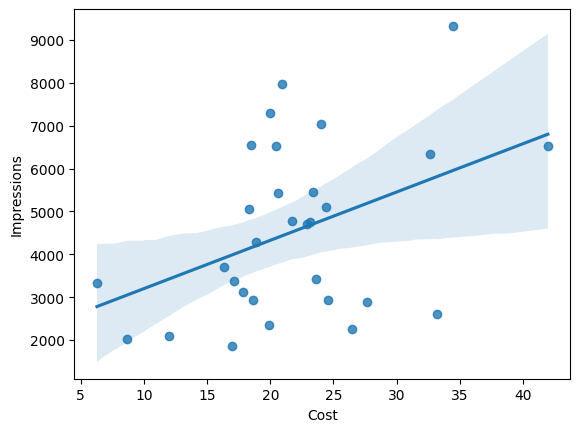

In [ ]:
sns.regplot(data = dailyData, x = 'Cost', y = 'Impressions')

There appears, to be a positive relationship between cost of advertising and impressions, and the below output from the linear regression suggests that there's a 2.2% chance that this pattern is not coincidence. It is standard to consider this "p-value" significant when it is less than 5%.

Therefore, we predict that for every dollar (USD) increase in cost of advertising, the number of impressions increases by 112.7.

In [ ]:
x = dailyData['Cost']
x = sm.add_constant(x)
y = dailyData['Impressions']

model = sm.OLS(y, x).fit()


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Impressions   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5.854
Date:                Sun, 30 Jul 2023   Prob (F-statistic):             0.0223
Time:                        18:51:16   Log-Likelihood:                -266.97
No. Observations:                  30   AIC:                             537.9
Df Residuals:                      28   BIC:                             540.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2072.7741   1071.639      1.934      0.0

We now plot a scatterplot to visually assess a relationship between cost and CTR. Because cost-per-click is directly related to cost, we do not try and use a linear regression.

<Axes: xlabel='Cost', ylabel='CTR'>

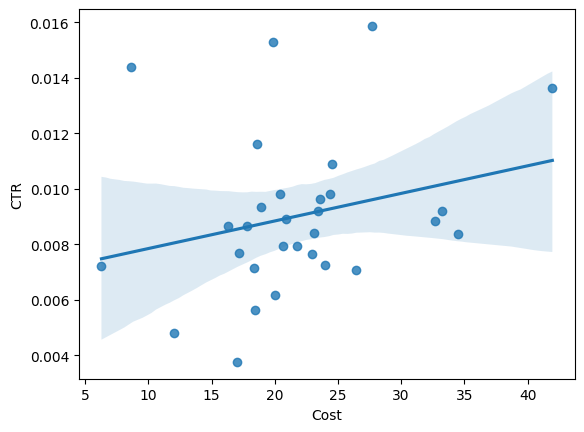

In [ ]:
sns.regplot(data = dailyData, x = 'Cost', y = 'CTR')

We observe a positive relationship in the above graph, however, based on the output below, there is a 17.3% chance of this relationship generating by chance, thus, we determine there is insignificant evidence of a relationship between cost and CTR.

In [ ]:
x = dailyData['Cost']
x = sm.add_constant(x)
y = dailyData['CTR']

model = sm.OLS(y, x).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                    CTR   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     1.960
Date:                Sun, 30 Jul 2023   Prob (F-statistic):              0.173
Time:                        18:59:12   Log-Likelihood:                 134.85
No. Observations:                  30   AIC:                            -265.7
Df Residuals:                      28   BIC:                            -262.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.002      4.193      0.0

## Time as a predicting factor

We now consider if the duration of the ad campaign has anything to do with the metrics recorded (number of impressions, CPC, and CTR).

<ipython-input-51-3018ac09b84b>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel = "Date", xticklabels = [
<ipython-input-51-3018ac09b84b>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.set_xticklabels(ax.axes.get_xticklabels(),


[Text(738605.0, 0, '2023-03-26'),
 Text(738610.0, 0, '2023-03-31'),
 Text(738615.0, 0, '2023-04-05'),
 Text(738620.0, 0, '2023-04-10'),
 Text(738625.0, 0, '2023-04-15'),
 Text(738630.0, 0, '2023-04-20'),
 Text(738635.0, 0, '2023-04-25'),
 Text(738640.0, 0, '2023-04-30'),
 Text(738645.0, 0, '2023-05-05')]

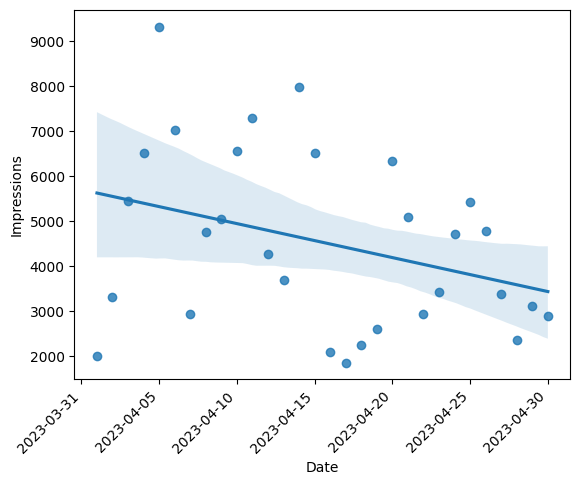

In [ ]:
ax = sns.regplot(data = dailyData, x = 'Ordinal Date', y = 'Impressions')

ax.set(xlabel = "Date", xticklabels = [
    date.fromordinal(int(item)) for item in ax.axes.get_xticks()
])

ax.axes.set_xticklabels(ax.axes.get_xticklabels(),
                        rotation = 45, horizontalalignment = 'right')

While there does appear to be a negative relationship in the graph above, the below output implies there is an insignificant amount of evidence to believe there is a negative relationship between time and number of impressions received.

In [ ]:
x = dailyData['Ordinal Date']
x = sm.add_constant(x)
y = dailyData['Impressions']

model = sm.OLS(y, x).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            Impressions   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     3.546
Date:                Sun, 30 Jul 2023   Prob (F-statistic):             0.0701
Time:                        19:08:48   Log-Likelihood:                -268.03
No. Observations:                  30   AIC:                             540.1
Df Residuals:                      28   BIC:                             542.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.577e+07   2.96e+07      1.883   

Plotting the date against the average CPC of a given day, we observe a slight positive relationship.

<ipython-input-53-c4fe4afe4f55>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel = "Date", xticklabels = [
<ipython-input-53-c4fe4afe4f55>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.set_xticklabels(ax.axes.get_xticklabels(),


[Text(738605.0, 0, '2023-03-26'),
 Text(738610.0, 0, '2023-03-31'),
 Text(738615.0, 0, '2023-04-05'),
 Text(738620.0, 0, '2023-04-10'),
 Text(738625.0, 0, '2023-04-15'),
 Text(738630.0, 0, '2023-04-20'),
 Text(738635.0, 0, '2023-04-25'),
 Text(738640.0, 0, '2023-04-30'),
 Text(738645.0, 0, '2023-05-05')]

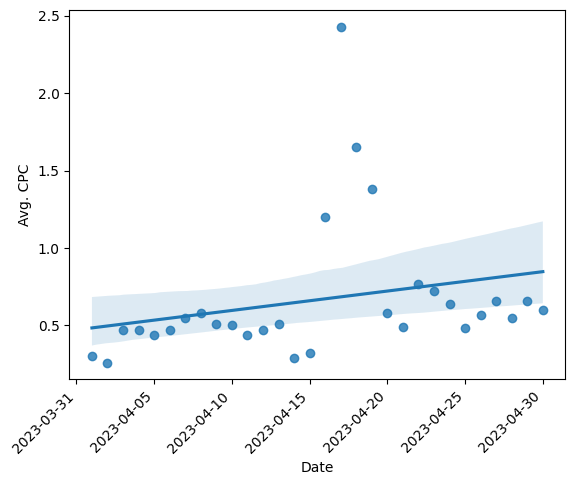

In [ ]:
ax = sns.regplot(data = dailyData, x = 'Ordinal Date', y = 'Avg. CPC')

ax.set(xlabel = "Date", xticklabels = [
    date.fromordinal(int(item)) for item in ax.axes.get_xticks()
])

ax.axes.set_xticklabels(ax.axes.get_xticklabels(),
                        rotation = 45, horizontalalignment = 'right')

However, based off the below output, there is insignificant evidence to suggest a negative relationship between CPC and time.

In [ ]:
x = dailyData['Ordinal Date']
x = sm.add_constant(x)
y = dailyData['Avg. CPC']

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Avg. CPC   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.780
Date:                Sun, 30 Jul 2023   Prob (F-statistic):              0.193
Time:                        19:09:51   Log-Likelihood:                -17.255
No. Observations:                  30   AIC:                             38.51
Df Residuals:                      28   BIC:                             41.31
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9253.9260   6936.097     -1.334   

Plotting CTR given the date suggests a slight positive relationship.

<ipython-input-55-ebfb67cacfe3>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(xlabel = "Date", xticklabels = [
<ipython-input-55-ebfb67cacfe3>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.axes.set_xticklabels(ax.axes.get_xticklabels(),


[Text(738605.0, 0, '2023-03-26'),
 Text(738610.0, 0, '2023-03-31'),
 Text(738615.0, 0, '2023-04-05'),
 Text(738620.0, 0, '2023-04-10'),
 Text(738625.0, 0, '2023-04-15'),
 Text(738630.0, 0, '2023-04-20'),
 Text(738635.0, 0, '2023-04-25'),
 Text(738640.0, 0, '2023-04-30'),
 Text(738645.0, 0, '2023-05-05')]

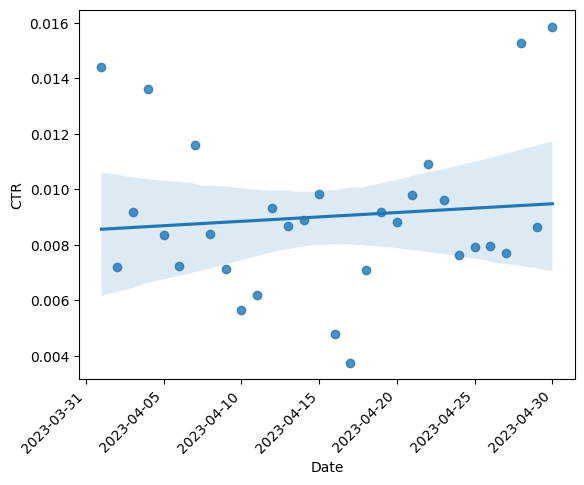

In [ ]:
ax = sns.regplot(data = dailyData, x = 'Ordinal Date', y = 'CTR')

ax.set(xlabel = "Date", xticklabels = [
    date.fromordinal(int(item)) for item in ax.axes.get_xticks()
])

ax.axes.set_xticklabels(ax.axes.get_xticklabels(),
                        rotation = 45, horizontalalignment = 'right')

Again, the below output suggests that this visual relationship is by chance.

In [ ]:
x = dailyData['Ordinal Date']
x = sm.add_constant(x)
y = dailyData['CTR']

model = sm.OLS(y, x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CTR   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.2719
Date:                Sun, 30 Jul 2023   Prob (F-statistic):              0.606
Time:                        19:39:03   Log-Likelihood:                 133.98
No. Observations:                  30   AIC:                            -264.0
Df Residuals:                      28   BIC:                            -261.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -23.3752     44.848     -0.521   

# Analyzing data considering the day of the week.

We use Tukey's Test to determine whether there is a significant difference in impressions, average CPC, CTR, or cost, given the day of the week. However, because this time period was only 30 days, there are only 3-4 data points for each day of the week, meaning even if there was suggestion of a relationship, this small sample size would cast doubt on this analysis.

In [ ]:
dayOfWeek = [
    'Sun',
    'Mon',
    'Tue',
    'Wed',
    'Thu',
    'Fri',
    'Sat'
]

## Impressions

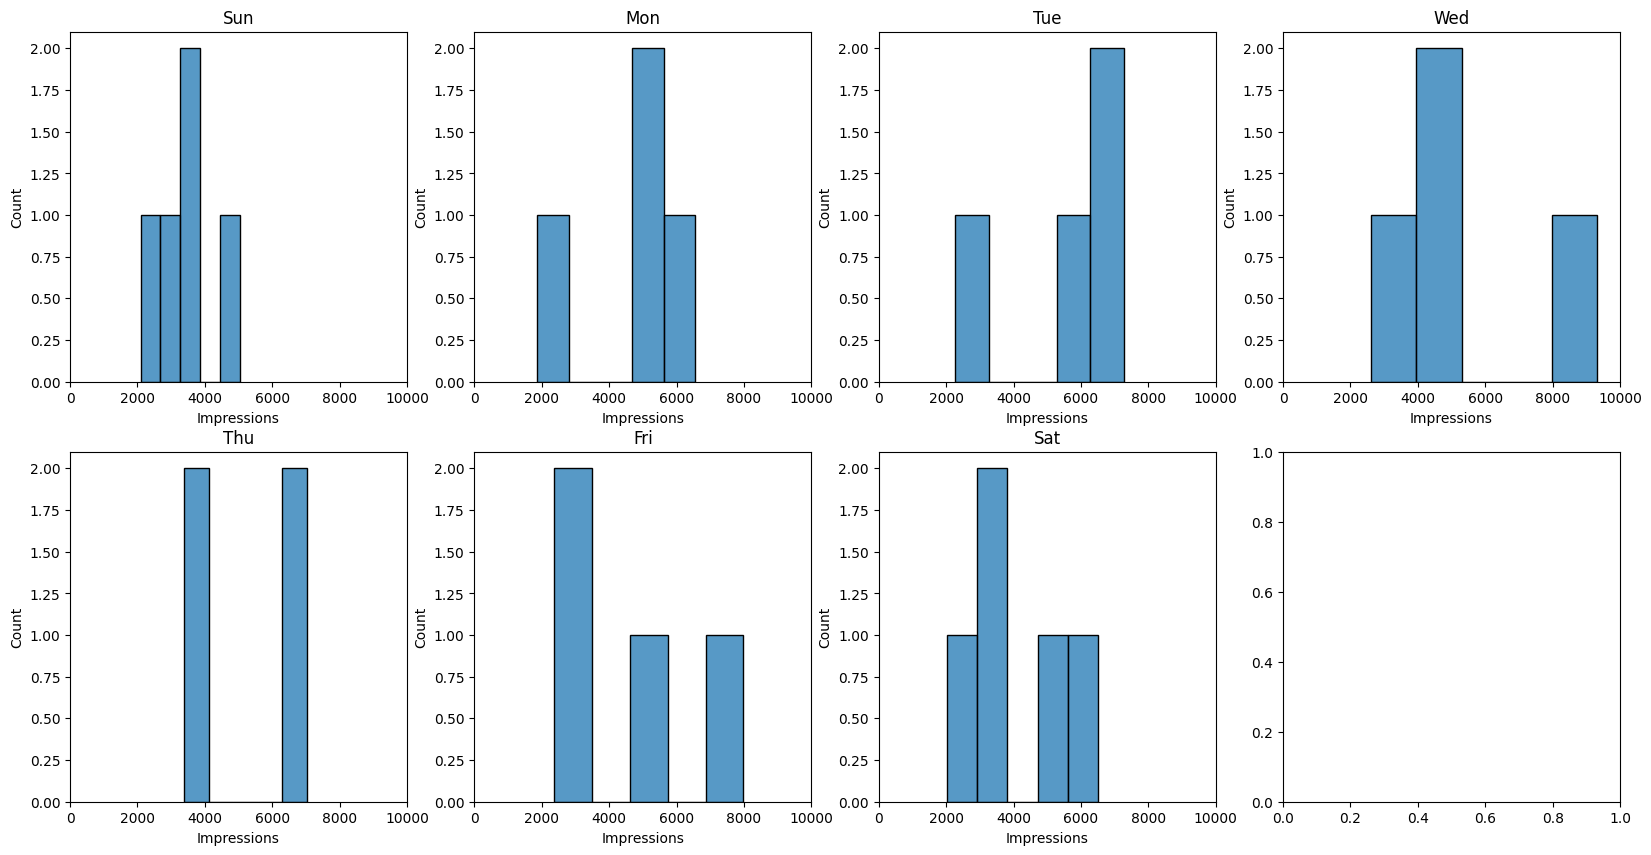

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

for i in range(7):
    sns.histplot(data = dailyData[dailyData['Day of Week'] == dayOfWeek[i]],
                 x = 'Impressions', ax = ax.flat[i], bins=5)
    ax.flat[i].set(title = dayOfWeek[i], xlim = (0, 10000))

The p-value being 0.7289 suggests there is a 72.89% chance this data pattern formed by chance, meaning there is insignificant evidence to believe there is a relationship between the day of the week and the number of impressions.

In [ ]:
stats.f_oneway(*[
    dailyData[dailyData['Day of Week'] == day]['Impressions'] for day in dayOfWeek
])

F_onewayResult(statistic=0.5979649016759035, pvalue=0.7289201798002523)

## Avg. CPC

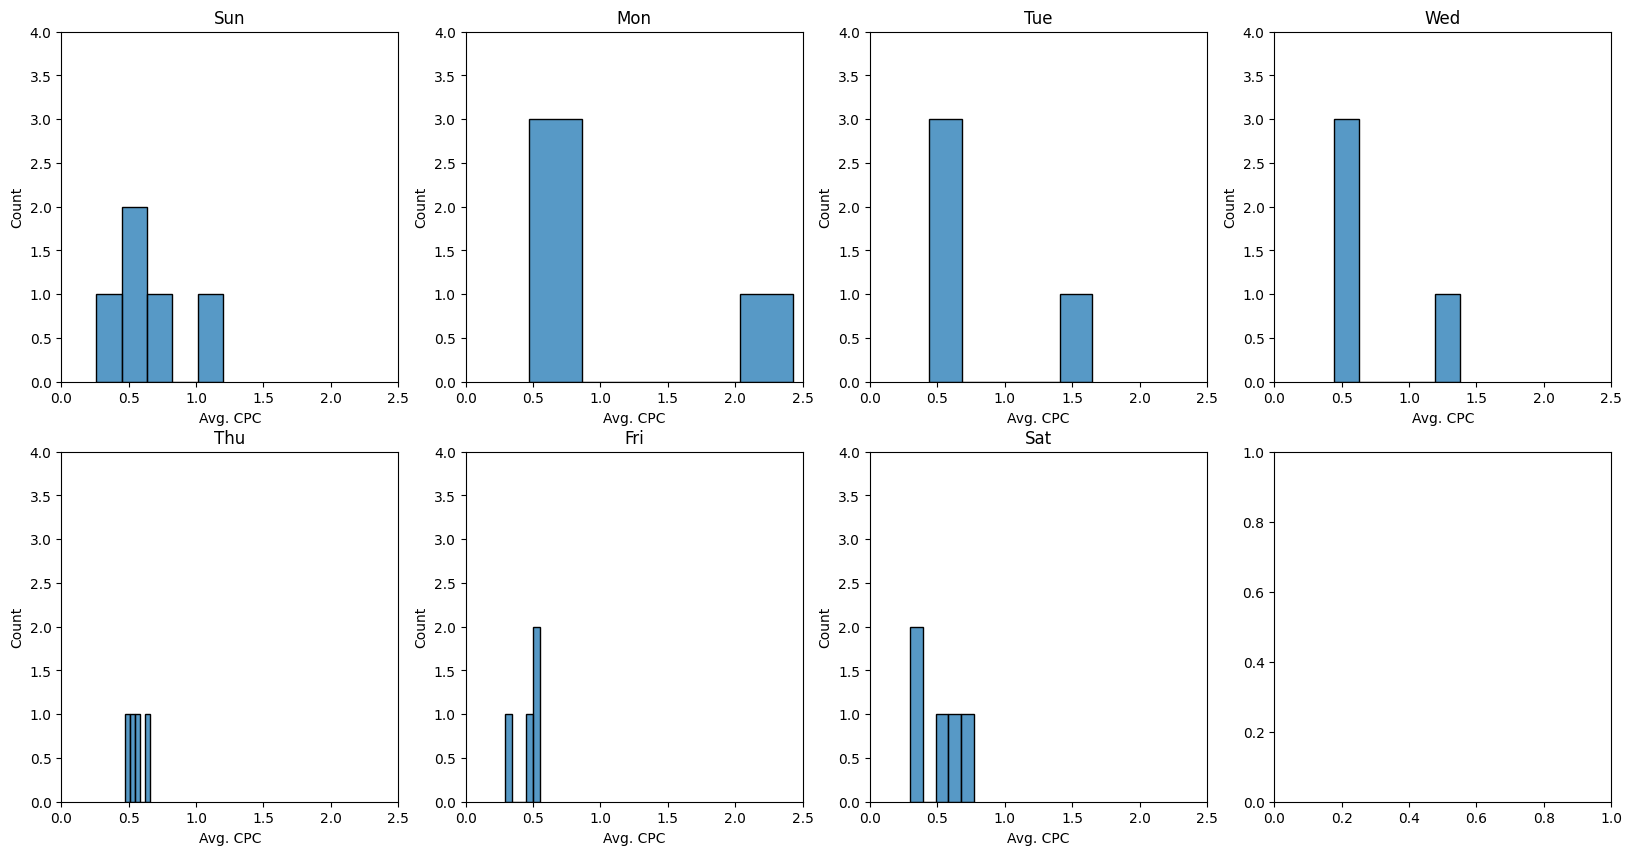

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

for i in range(7):
    sns.histplot(data = dailyData[dailyData['Day of Week'] == dayOfWeek[i]],
                 x = 'Avg. CPC', ax = ax.flat[i], bins=5)
    ax.flat[i].set(title = dayOfWeek[i], xlim = (0, 2.5), ylim = (0, 4))

The p-value being 0.7137 suggests there is a 71.37% chance this data pattern formed by chance, meaning there is insignificant evidence to believe there is a relationship between the day of the week and average CPC.

In [ ]:
stats.f_oneway(*[
    dailyData[dailyData['Day of Week'] == day]['Avg. CPC'] for day in dayOfWeek
])

F_onewayResult(statistic=0.6181079674882056, pvalue=0.7137497702183118)

## Click through rate

<ipython-input-34-02c06676b5a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flat[i].set_xticklabels(ax.flat[i].get_xticks(), rotation = 90);
<ipython-input-34-02c06676b5a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flat[i].set_xticklabels(ax.flat[i].get_xticks(), rotation = 90);
<ipython-input-34-02c06676b5a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flat[i].set_xticklabels(ax.flat[i].get_xticks(), rotation = 90);
<ipython-input-34-02c06676b5a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flat[i].set_xticklabels(ax.flat[i].get_xticks(), rotation = 90);
<ipython-input-34-02c06676b5a6>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.flat[i].set_xticklabels(ax.flat[i].get_xticks(), rotation = 90);
<ipython-input-34-02c06676b5a6>:8: UserWarning: FixedFormatter should only be used together with Fix

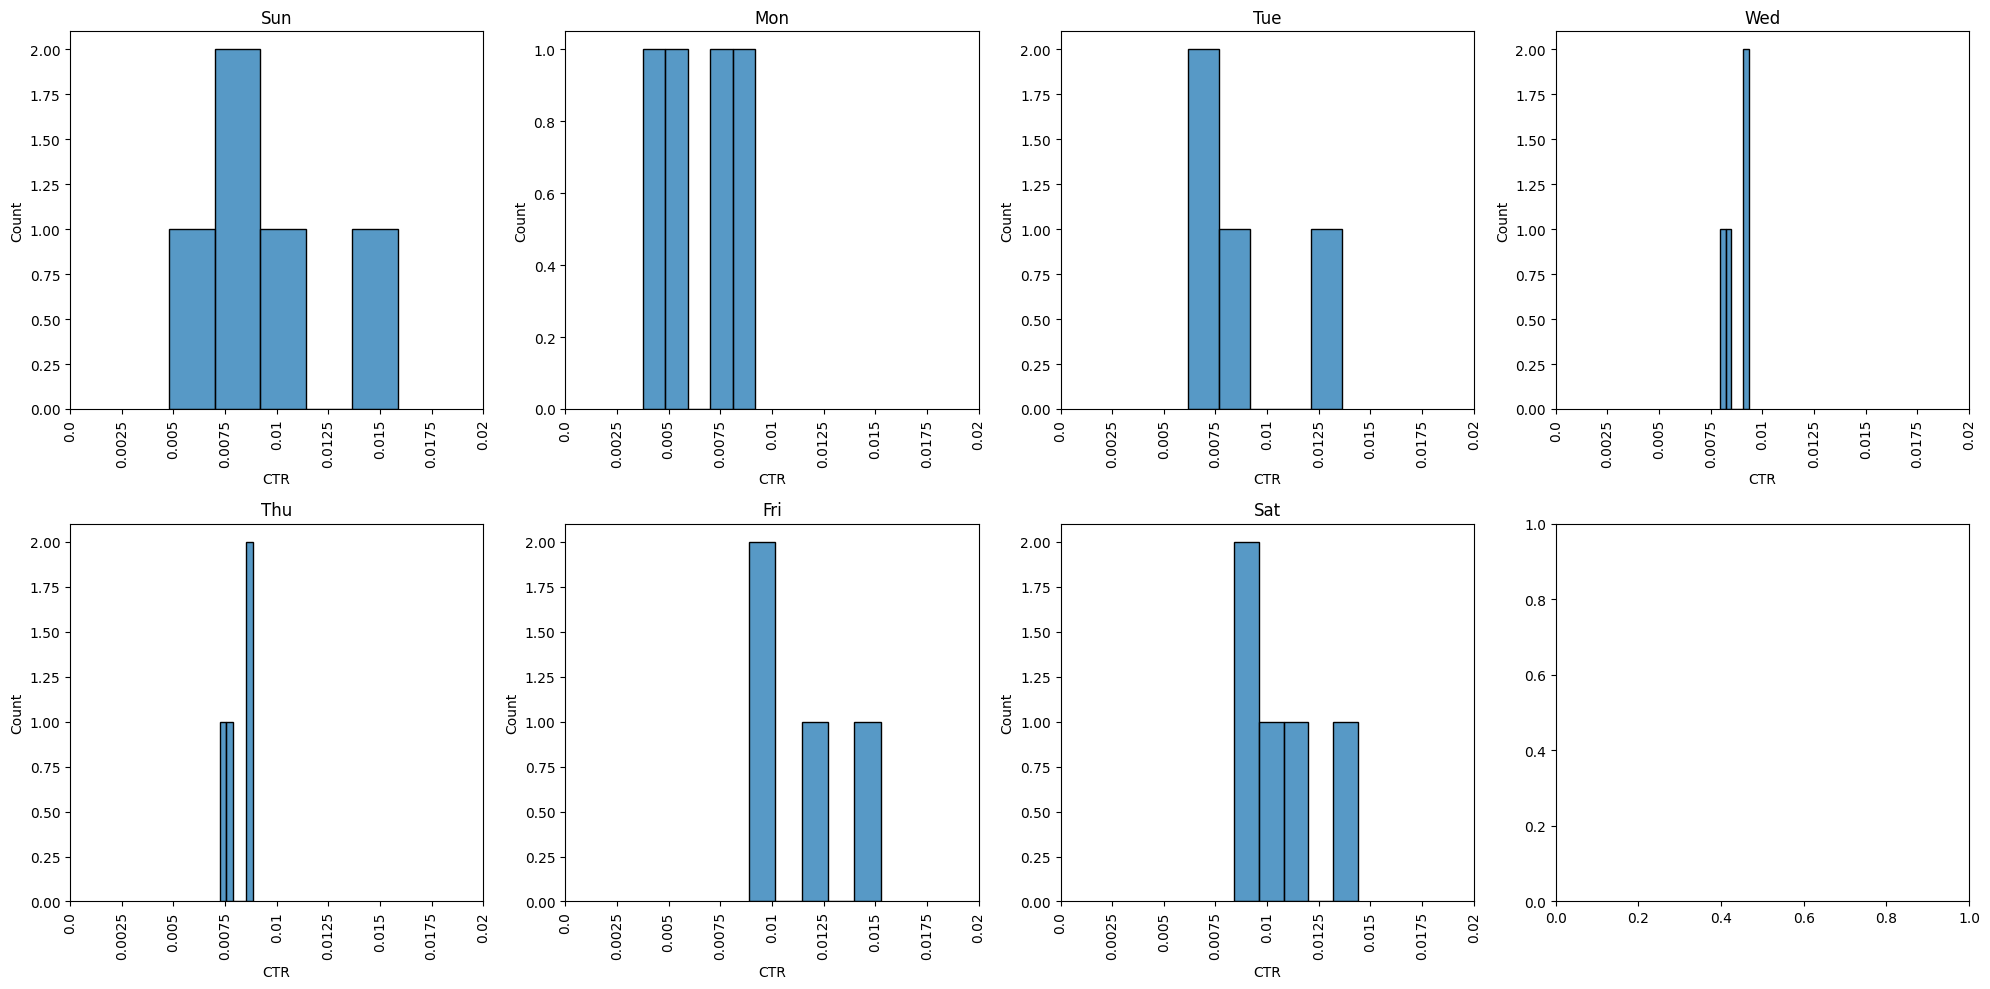

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

for i in range(7):
    sns.histplot(data = dailyData[dailyData['Day of Week'] == dayOfWeek[i]],
                 x = 'CTR', ax = ax.flat[i], bins=5)
    ax.flat[i].set(title = dayOfWeek[i], xlim=(0, 0.02))
    # https://stackabuse.com/rotate-axis-labels-in-matplotlib/
    ax.flat[i].set_xticklabels(ax.flat[i].get_xticks(), rotation = 90);

fig.tight_layout()

The p-value being 0.2710 suggests there is a 27.10% chance this data pattern formed by chance, meaning there is insignificant evidence to believe there is a relationship between the day of the week and CTR.

In [ ]:
stats.f_oneway(*[
    dailyData[dailyData['Day of Week'] == day]['CTR'] for day in dayOfWeek
])

F_onewayResult(statistic=1.3500260570535527, pvalue=0.276102648507923)

## Cost

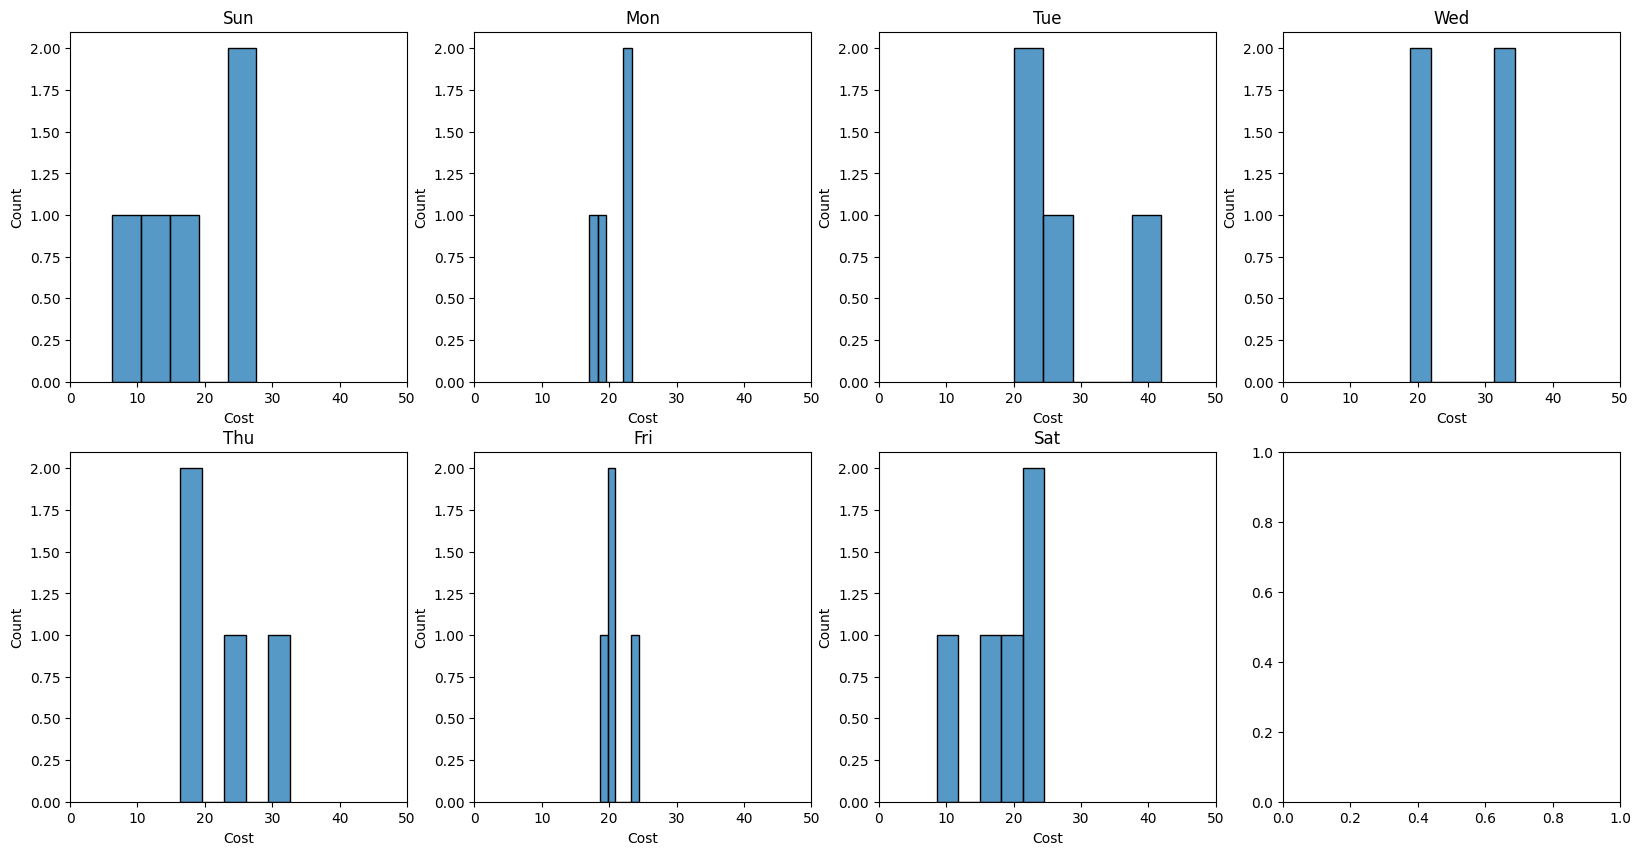

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))

for i in range(7):
    sns.histplot(data = dailyData[dailyData['Day of Week'] == dayOfWeek[i]],
                 x = 'Cost', ax = ax.flat[i], bins=5)
    ax.flat[i].set(title = dayOfWeek[i], xlim = (0, 50))

The p-value being 0.3346 suggests there is a 33.46% chance this data pattern formed by chance, meaning there is insignificant evidence to believe there is a relationship between the day of the week and the number of cost.

In [ ]:
stats.f_oneway(*[
    dailyData[dailyData['Day of Week'] == day]['Cost'] for day in dayOfWeek
])

F_onewayResult(statistic=1.214511622546099, pvalue=0.3346222865056601)

# Analyzing data by demographics

Because this data has already been aggregated, it is difficult to perform analysis. Below are some pie charts representing the distribution for the demographics measured (gender and age).

In [ ]:
demoData = pd.read_csv('! Demographics(Gender_Age_2023.04.01-2023.04.30).csv')

demoData['Impressions'] = demoData['Impressions'].apply(
    lambda x: int(''.join(x.split(','))))
demoData['Percent of known total'] = demoData['Percent of known total'].apply(
    lambda x: float(x[:-1])
) # removing % sign

demoData.head()

,Gender,Age Range,Impressions,Percent of known total
0,Male,18-24,7393,19.84
1,Male,25-34,5323,14.29
2,Male,35-44,4337,11.64
3,Male,45-54,3627,9.73
4,Male,55-64,3256,8.74


[Text(0.5, 1.0, 'Impressions by Gender')]

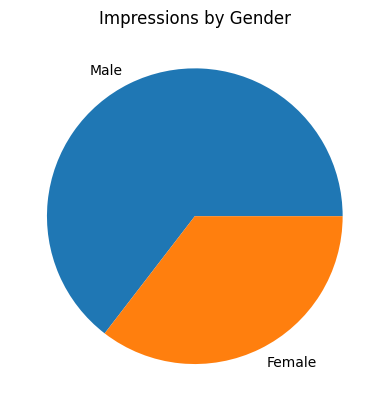

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.pie([sum(demoData[demoData['Gender'] == 'Male']['Impressions']),
        sum(demoData[demoData['Gender'] == 'Female']['Impressions'])],
       labels = ["Male", "Female"])

ax.set(title = 'Impressions by Gender')

[Text(0.5, 1.0, 'Impressions by Age Range')]

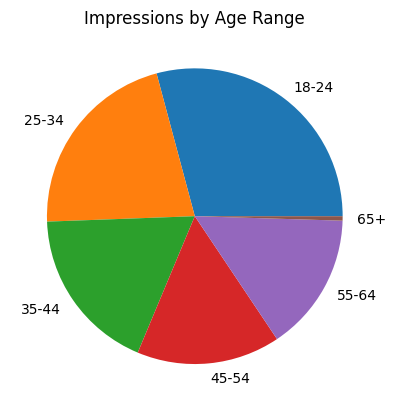

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.pie([sum(demoData[demoData['Age Range'] == ageRange]['Impressions']) for ageRange in demoData['Age Range'][:6]],
       labels = demoData['Age Range'][:6])

ax.set(title = 'Impressions by Age Range')

([<matplotlib.patches.Wedge at 0x7ddaa2e3b310>,
 [Text(0.6259166084911473, 0.9045597820016873, '18-24'),
  Text(-0.957073607388024, 0.5422269912511497, '25-34'),
  Text(-0.8077839538870889, -0.7466492374887566, '35-44'),
  Text(0.2350595658628043, -1.0745915505420607, '45-54'),
  Text(0.98733184729375, -0.4849492997412319, '55-64'),
  Text(1.0998649287504312, -0.017237705903322454, '65+')])

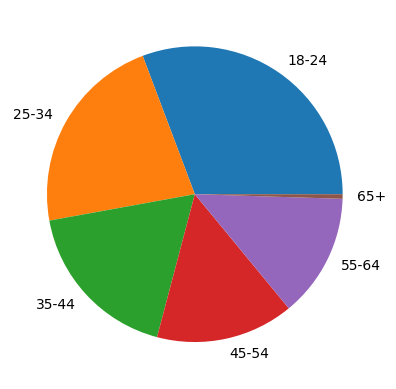

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.pie(demoData[demoData['Gender'] == 'Male']['Impressions'],
       labels = demoData['Age Range'][:6])

ax.set(title = "Impressions by Age Range (Male)")

[Text(0.5, 1.0, 'Impressions by Age Range (Female)')]

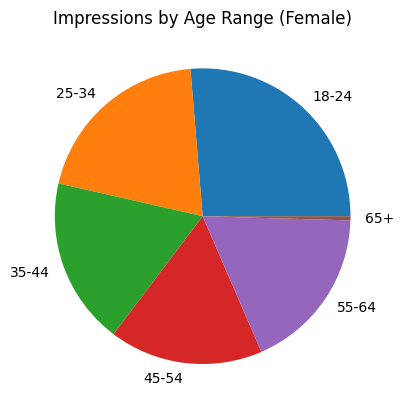

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.pie(demoData[demoData['Gender'] == 'Female']['Impressions'],
       labels = demoData['Age Range'][:6])

ax.set(title = "Impressions by Age Range (Female)")

# Analyzing data by device

Again, because the data has already been aggregated, it is difficult to meaningfully ascertain any relationships. Instead, we plot the data.

In [ ]:
devData = pd.read_csv('! Devices(2023.04.01-2023.04.30).csv')

devData['Impressions'] = devData['Impressions'].apply(
    lambda x: int(''.join(x.split(','))))
devData['Clicks'] = devData['Clicks'].apply(int)
devData['Cost'] = devData['Cost'].apply(
    lambda x: float(x[1:])
) # removing $ sign



def getDevCPC():
    res = []
    for i in range(len(devData)):
        res.append(devData.iloc[i]['Clicks'] / devData.iloc[i]['Cost'])
    return res

devData['CPC'] = getDevCPC()

def getDevCTR():
    res = []
    for i in range(len(devData)):
        res.append(devData.iloc[i]['Clicks'] / devData.iloc[i]['Impressions'])
    return res

devData['CTR'] = getDevCTR()

devData.head()

,Device,Cost,Impressions,Clicks,CPC,CTR
0,Computers,87.51,8619,133,1.519826,0.015431
1,Mobile phones,378.00,75617,686,1.814815,0.009072
2,Tablets,105.88,42189,380,3.588969,0.009007
3,TV screens,84.08,9645,1,0.011893,0.000104


Looking at the following barplots, there is arguably a trend with tablets having a higher CPC, given that tablets received a large number of impressions and also has a visibly higher CPC than other devices.

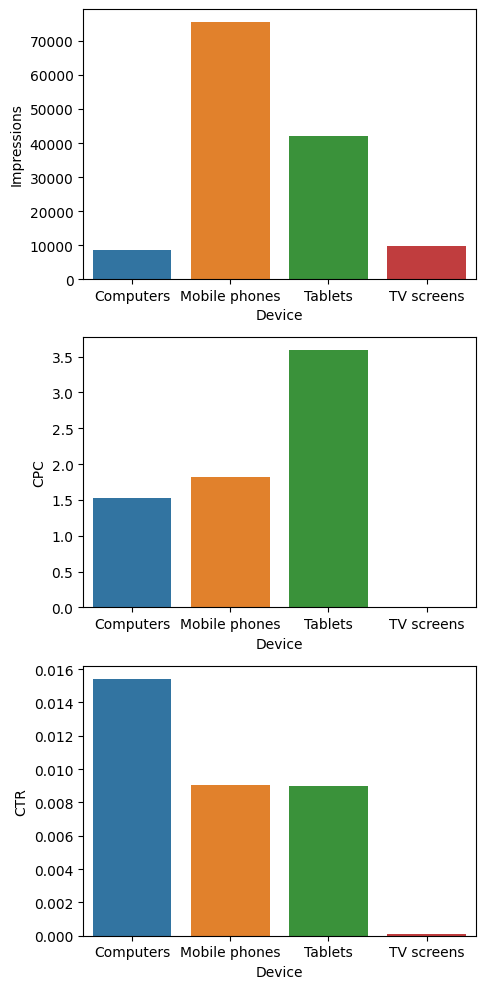

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (5, 10))
for i in range(len(cols := ['Impressions', 'CPC', 'CTR'])):
    sns.barplot(data = devData, x = 'Device', y = cols[i],
                ax = ax[i])

fig.tight_layout()

# Analyzing data by network

Finally, because this data is also already aggregated, it is difficult to perform meaningful analysis. Below are some plots.

In [ ]:
networkData = pd.read_csv('! Networks(2023.04.01-2023.04.30).csv')

networkData['Clicks'] = networkData['Clicks'].apply(
    lambda x: int(''.join(x.split(',')))
)
networkData['Cost'] = networkData['Cost'].apply(
    lambda x: float(x[1:])
)
networkData['Avg. CPC'] = networkData['Avg. CPC'].apply(
    lambda x: float(x[1:])
)

networkData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Network   4 non-null      object 
 1   Clicks    4 non-null      int64  
 2   Cost      4 non-null      float64
 3   Avg. CPC  4 non-null      float64
dtypes: float64(2), int64(1), object(1)
memory usage: 256.0+ bytes


,Network,Clicks,Cost,Avg. CPC
0,Google search,65,78.20,1.20
1,Search partners,26,21.41,0.82
2,Display network,1046,248.47,0.24
3,YouTube,63,307.39,4.88


The most surprising value is YouTube having a high average CPC, however, given how few clicks came from YouTube, and the fact that we don't know how many impressions YouTube received, it is difficult to determine whether this trend is meaningful.

<Axes: xlabel='Network', ylabel='Avg. CPC'>

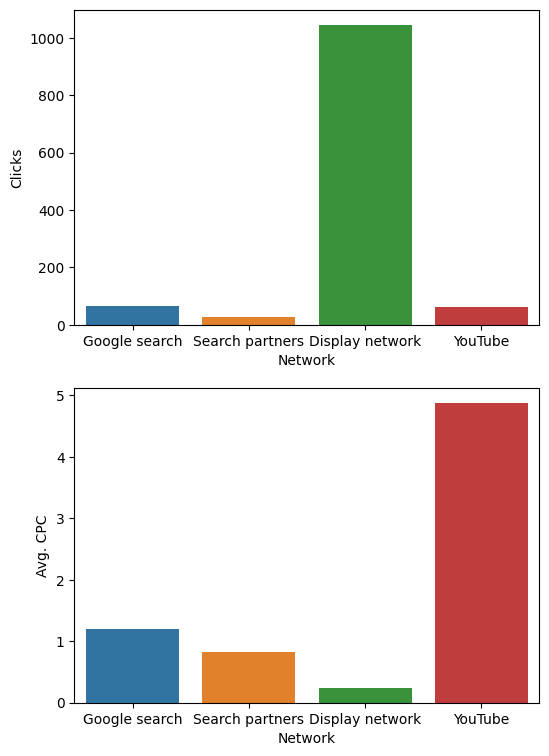

In [ ]:
fig, ax = plt.subplots(2, 1, figsize =(6, 9))
sns.barplot(data = networkData, x = 'Network', y = 'Clicks',
            ax = ax[0])
sns.barplot(data = networkData, x = 'Network', y = 'Avg. CPC',
            ax = ax[1])